## Homework 02-2: due 2022/03/31 23:59 (70%)

### - Tutorial : https://machinelearningmastery.com/pytorch-tutorial-develop-deep-learning-models/

### - After you go through the tutorials, you should be able to work on this assignment.

### - Please answer the following questions and work directly on this jupyter notebook.

### - Make sure the code can be run and show the result and figures properly.

### - Please write down your observation with markdown in this notebook briefly.



#### You will train a regression model in this part. The data is **Concrete Compressive Strength Dataset**, you can find the details of each column at https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength. In this part, please predict the **strength of concrete**.

In [35]:
# Import necessory modules
%matplotlib inline
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

In [65]:
# For reproduce the result
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### 1. Define the model and dataset (10%)

#### 1.1 Please follow the tutorial to create a class ***ConcreteDataset***, for loading the data you need and also do the ***Min-Max scaling*** to the ***feature and label***. (5%)

In [66]:
class ConcreteDataset(Dataset):
    def __init__(self, path):
        # read X and y
        df = pd.read_csv(path)
        self.X = df.iloc[:, :-1].values.astype('float32')
        self.y = df.iloc[:, -1].values.astype('float32')
        # min-max normalization
        self.scalerX = MinMaxScaler()
        self.scalery = MinMaxScaler()
        self.X = self.scalerX.fit_transform(self.X)
        self.y = self.scalery.fit_transform(self.y.reshape(-1, 1))

    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
    
    # get a row at an index
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]       

#### 1.2 By following the tutorial, try to create a class ***MLP(Neural Network)*** with ***three hidden layers*** as your network architecture. Also, for the convenience of implementation, please set the numbers of hidden nodes and the activation functions as input variables to the foward functions.(5%) 

In [67]:
class MLP(nn.Module):
    def __init__(self, n_inputs, node_layer1, node_layer2, node_layer3, activation, act_output):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n_inputs, node_layer1),
            activation,
            nn.Linear(node_layer1, node_layer2),
            activation,
            nn.Linear(node_layer2, node_layer3),
            activation,
            nn.Linear(node_layer3, 1),
            act_output
        )
        
    def forward(self, X):
        return self.model(X)

### 2. Train the model (60%)

#### 2.1 Please load the ***train.csv/ validation.csv*** in ./data, and turn them into dataloader with batch size 64 and determine whether shuffle or not. (5%)

In [68]:
train_dataset = ConcreteDataset('./data/train.csv')
val_dataset = ConcreteDataset('./data/validation.csv')
# https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
# DataLoader can be enumerated, yielding one batch worth of samples each iteration.
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)

#### 2.2 Create two MLP model from the table below and ***print the model*** (10%):
| | Hidden Layer 1| Hidden Layer 2| Hidden Layer 3| Activation in each hidden nodes | Activation for output |
|:---:|:---:|:---:|:---:|:---:|:---:|
|***Model1***| 256 | 64 | 8 | Tanh | Tanh |
|***Model2***| 64 | 16 | 8 | Tanh | Identity |

In [40]:
models = {"Model1": MLP(n_inputs=8, node_layer1=256, node_layer2=64, node_layer3=8, activation=nn.Tanh(), act_output=nn.Tanh()),
            "Model2": MLP(n_inputs=8, node_layer1=64, node_layer2=16, node_layer3=8, activation=nn.Tanh(), act_output=nn.Identity()),
}
for name, model in models.items():
    print(f"{name}:\n{model}")

Model1:
MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Tanh()
  )
)
Model2:
MLP(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=8, bias=True)
    (5): Tanh()
    (6): Linear(in_features=8, out_features=1, bias=True)
    (7): Identity()
  )
)


#### 2.3 Train the above two models with the same hyperpameters below and do the validation in every epoch. Choose the appropriate type of loss function according to the task. (25%)
##### (Note. You should record the training/validation loss every epoch)


| | Learning rate | epochs | optimizer | momentum |
|:---:|:---:|:---:|:---:|:---:|
|***Hyperparameter***| 0.01 | 300 | SGD | 0.9 |

In [41]:
def train_and_val(models, train_dl, val_dl, momentum=0.9, criterion=nn.MSELoss(), epochs=300, learning_rate=0.01, save_model=False):
    epoch_loss = {}

    for name, model in models.items():
        epoch_loss[name] = {"Training Loss": [], "Validation Loss": []}
        optimizer = optim.SGD(models[name].parameters(), lr=learning_rate, momentum=momentum)
        
        for epoch in tqdm(range(epochs)):
            train_loss, val_loss = [], []

            # enumerate mini-batches
            for X, y in train_dl:
                # clear the gradients
                optimizer.zero_grad()
                y_pred = model(X)
                # compute the loss
                loss = criterion(y_pred, y)
                # compute the gradients
                loss.backward()
                # update model parameters
                optimizer.step()
                train_loss.append(loss.item())

            for X, y in val_dl:
                y_pred = model(X)
                loss = criterion(y_pred, y)
                val_loss.append(loss.item())

            epoch_loss[name]["Training Loss"].append(sum(train_loss)/len(train_loss))
            epoch_loss[name]["Validation Loss"].append(sum(val_loss)/len(val_loss))

            # https://blog.csdn.net/weixin_40522801/article/details/106563354
            if save_model:
                torch.save(model.state_dict(), f"{name}.pth")

    return epoch_loss
epoch_loss = train_and_val(models, train_dl, val_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

#### 2.4 Please include the plot that shows how the training/validation loss vary with the training epoch. Show the plots using the above two models and write down the observation. (5%)
##### Here is the example figure
![train_ex.png](https://github.com/tingyan08/Deep-Learning-and-Computer-Vision/blob/main/HW2/img/HW2-2.png?raw=true)

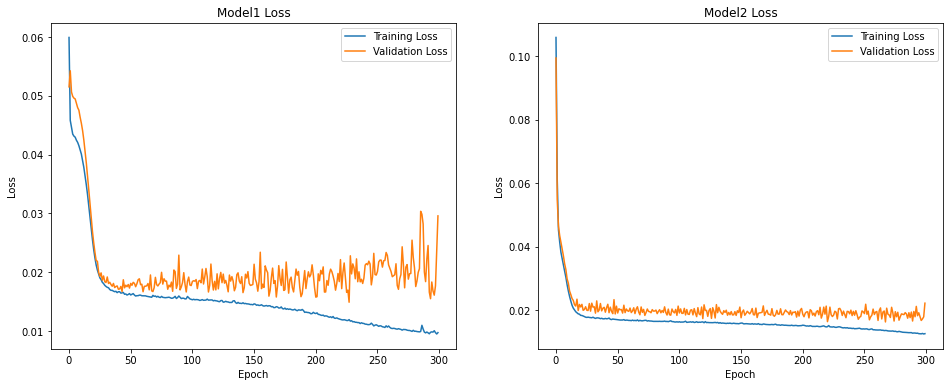

In [43]:
def draw_loss(epoch_loss):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    for i, (name, model) in enumerate(models.items()):
        ax[i].plot(epoch_loss[name]["Training Loss"], label="Training Loss")
        ax[i].plot(epoch_loss[name]["Validation Loss"], label="Validation Loss")
        ax[i].set_xlabel("Epoch")
        ax[i].set_ylabel("Loss")
        ax[i].set_title(f"{name} Loss")
        ax[i].legend()
    plt.show()
    
draw_loss(epoch_loss)

- Overfitting happened roughly at the epoch 50 in both models, as the validation loss gradually increased and the training loss continously decreased. We could do early stopping or set a relatively lower epoch to train the model as below.

#### 2.5 From the observation of the previous question, please determine an appropriate epoch and retrain the two models to avoid overfitting. Also, draw the loss plot of two models and save the last model as ***model1.pth*** and ***model2.pth***. (10%)
##### (Note. You should reload the models and the optimizer, otherwise, you will resume from the previous stop.)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

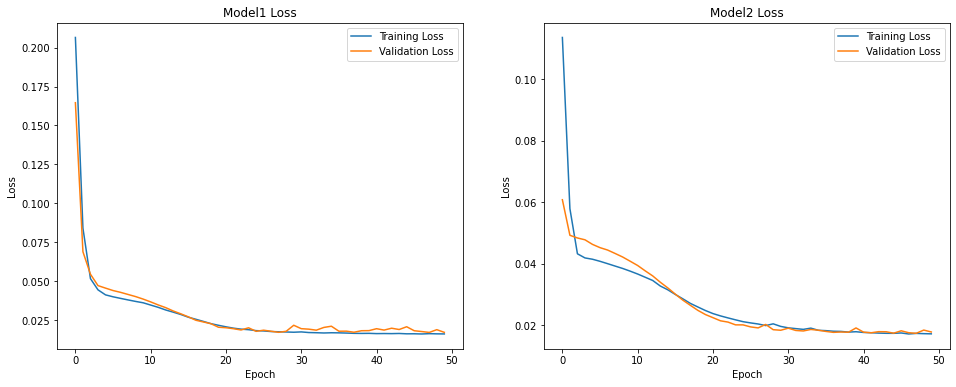

In [72]:
train_dataset = ConcreteDataset('./data/train.csv')
val_dataset = ConcreteDataset('./data/validation.csv')
train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=64, shuffle=False)
models = {"Model1": MLP(n_inputs=8, node_layer1=256, node_layer2=64, node_layer3=8, activation=nn.Tanh(), act_output=nn.Tanh()),
            "Model2": MLP(n_inputs=8, node_layer1=64, node_layer2=16, node_layer3=8, activation=nn.Tanh(), act_output=nn.Identity()),
}
epoch_loss = train_and_val(models, train_dl, val_dl, epochs=50, save_model=True)
draw_loss(epoch_loss)

#### 2.6 Please load the checkpoints saved from previous question and calculate the mean squared error on test dataset for two models respectively. Also, make a dataframe with target and prediction like below and save it as ***regression.csv*** (5%)
|Target|Model1|Model2|
|:---:|:---:|:---:|
|24.05|26.35|27.04|
|21.67|32.78|21.95|

In [91]:
from sklearn.metrics import mean_squared_error

def evaluate(models, test_dataset):
    test_dl = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    table = {}

    for name, model in models.items():   
        model.load_state_dict(torch.load(f"{name}.pth"))
        model.eval()

        for X, y in test_dl:
            # predict on the test set
            y_pred = model(X)
            y_pred = test_dataset.scalery.inverse_transform(y_pred.detach().numpy())
            y = test_dataset.scalery.inverse_transform(y.detach().numpy())
            # compute the MSE
            mse = mean_squared_error(y, y_pred)
            print(f"{name} MSE: {mse:.4f}")

            # save predictions and targets in a table
            table["Target"] = y.flatten()
            table[name] = y_pred.flatten()

    # save the table in a csv file
    pd.DataFrame(table).to_csv("regression.csv", index=False)

test_dataset = ConcreteDataset('./data/test.csv')
models = {"Model1": MLP(n_inputs=8, node_layer1=256, node_layer2=64, node_layer3=8, activation=nn.Tanh(), act_output=nn.Tanh()),
            "Model2": MLP(n_inputs=8, node_layer1=64, node_layer2=16, node_layer3=8, activation=nn.Tanh(), act_output=nn.Identity()),
}
evaluate(models, test_dataset)

Model1 MSE: 108.7412
Model2 MSE: 122.8780


In [92]:
pd.read_csv("regression.csv")

,Target,Model1,Model2
0,26.06,31.003767,30.810116
1,10.35,6.224145,9.193416
2,74.99,46.759000,47.689472
3,59.00,46.259070,47.396310
4,52.12,39.185190,31.695920
...,...,...,...
98,33.40,28.163286,25.617887
99,39.27,23.509684,21.740128
100,18.13,9.876916,11.649975
101,33.01,22.899261,24.561768
